In [49]:
import pandas as pd
import numpy as np
import json
from Bio import SeqIO
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
#Import organized Auspice data
df = pd.read_csv('../dataframes/auspice_df.csv', index_col=0)
egg_df = pd.read_csv('../dataframes/egg_df.csv', index_col=0)
mut_df = pd.read_csv('../dataframes/auspice_by_tipmut.csv', index_col=0)

In [51]:
#Define positions
positions= [194,186,160,225,219,156,203,138]

In [61]:
#Find top tip mutations
top_muts = {}
for pas_type in mut_df['passage'].unique():
    top = mut_df[mut_df.passage==pas_type].groupby('mutation')['mutation'].count().sort_values(ascending=False)[:10]
    top_muts[pas_type] = list((g_name, g) for g_name, g in top.iteritems())

total_unpass = len(mut_df[mut_df.passage=='0'])
total_cell = len(mut_df[mut_df.passage=='cell'])
total_egg = len(mut_df[mut_df.passage=='egg'])
print('Number of strains with this mutation \n(out of ' + str(total_unpass)+ ' un-passaged strains and '+ str(total_cell)+ ' cell-passaged strains and '+ str(total_egg) + ' egg-passaged strains)')
print(pd.DataFrame(top_muts))

Number of strains with this mutation 
(out of 450 un-passaged strains and 654 cell-passaged strains and 344 egg-passaged strains)
               0            cell             egg
0   (HA1D53N, 8)  (HA1R261Q, 12)  (HA1G186V, 53)
1  (HA1R261Q, 6)  (HA2A201V, 11)  (HA1L194P, 51)
2  (HA1S262N, 6)  (HA1T160K, 11)  (HA1T160K, 27)
3  (HA2N116S, 6)   (HA1D53N, 10)  (HA1S219F, 17)
4  (HA2A201V, 6)  (HA1N225D, 10)  (HA1A138S, 13)
5  (HA1N122D, 4)   (HA1S262N, 9)  (HA1D225G, 13)
6  (HA1T160I, 4)    (HA2V18M, 8)  (HA1S219Y, 12)
7  (HA1K207R, 4)   (HA1I140M, 8)  (HA1T203I, 12)
8  (HA1V309I, 4)    (HA1Y94H, 7)   (HA1H156Q, 9)
9  (HA1R142K, 4)    (HA1R33Q, 6)   (HA1H156R, 8)


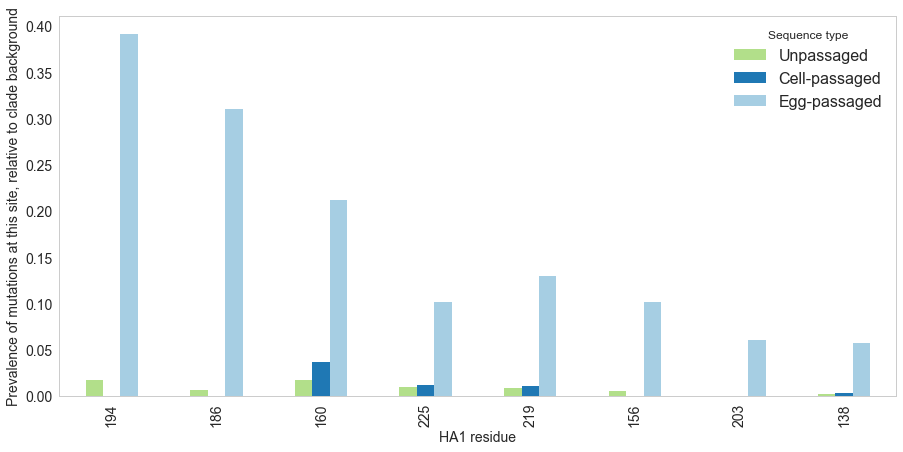

In [288]:
#A. Most prevalent egg-passaged mutations (all top 10 tip mutation sites)
mut_prev_df = pd.DataFrame()
for p in positions:
    mut_prev= df.groupby('passage')['mut'+str(p)].value_counts(normalize=True)
    mut_prev.name= 'mut_prev'+str(p)
    mut_prev = mut_prev.reset_index().set_index('passage')
    mut_prev_df[p] = mut_prev[mut_prev['mut'+str(p)]==1]['mut_prev'+str(p)]

fig, ax = plt.subplots(figsize=(15,7))
fig = mut_prev_df.T.plot(kind='bar', ax=ax, color=['#b2df8a','#1f78b4','#a6cee3'])
plt.xlabel('HA1 residue', size=14)
plt.ylabel('Prevalence of mutations at this site, relative to clade background', size=14)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Unpassaged", "Cell-passaged", "Egg-passaged"], title='Sequence type', loc=1, fontsize=16)
ax.tick_params(axis='both', labelsize=14)
ax.grid(False)

Text(0,0.5,u'Number of egg-passaged sequences')

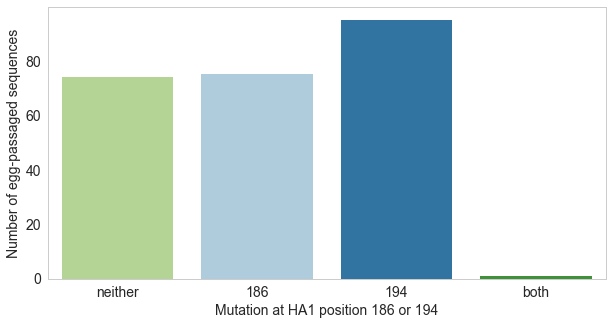

In [286]:
#B. Mutations at sites 194 and 186 are mutually exclusive
b_group = egg_df.groupby('mut194')['mut186'].value_counts()

b_dict = {}
for (mut194,mut186), g in b_group.iteritems():
    b_dict[str(mut194)+str(mut186)]=[g]

b_df = pd.DataFrame(b_dict).T.reset_index().rename(columns={'index':'mutation', 0:'prevalence'})
b_df.mutation = b_df.mutation.map({'00':'neither', '01':'186', '10':'194', '11':'both'})

fig, ax = plt.subplots(figsize=(10,5))
ax.grid(False)
fig = sns.barplot(x='mutation', y='prevalence', data=b_df, ax=ax, palette=['#b2df8a','#a6cee3','#1f78b4','#33a02c'])
ax.tick_params(axis='both', labelsize=14)
plt.xlabel('Mutation at HA1 position 186 or 194', size=14)
plt.ylabel('Number of egg-passaged sequences', size=14)

Text(0,0.5,u'Number of egg-passaged sequences')

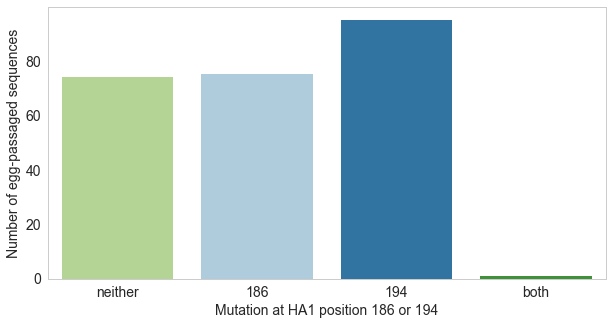

In [285]:
#B. better way...
b_df = egg_df.groupby(['mut194','mut186']).size().reset_index().rename(columns={0:'prevalence'})
b_df['mut194_186'] = np.select(((b_df.mut194==0)&(b_df.mut186==0),
                                (b_df.mut194==1)&(b_df.mut186==0),
                                (b_df.mut194==0)&(b_df.mut186==1),
                                (b_df.mut194==1)&(b_df.mut186==1)
                               ),('neither','194','186','both'))


b_df = b_df.loc[:,['mut194_186', 'prevalence']]

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='mut194_186',y='prevalence',data=b_df, ax=ax, palette=['#b2df8a','#a6cee3','#1f78b4','#33a02c'])
ax.grid(False)
ax.tick_params(axis='both', labelsize=14)
plt.xlabel('Mutation at HA1 position 186 or 194', size=14)
plt.ylabel('Number of egg-passaged sequences', size=14)

Text(0,0.5,u'Number of egg-passaged sequences')

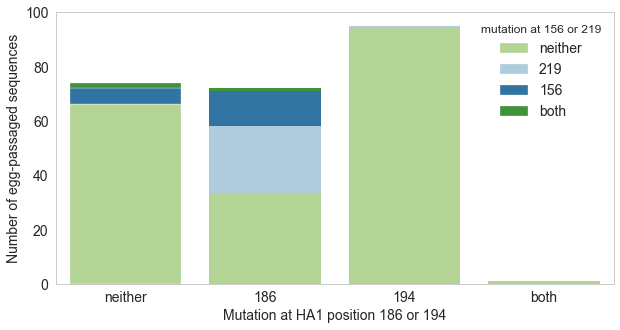

In [307]:
#C. Positions 156 and 219 do not mutate if 194 is mutated
c_df = egg_df.groupby(['mut194','mut186','mut156','mut219']).size().reset_index().rename(columns={0:'prevalence'})

c_df['mut194_186'] = np.select(((c_df.mut194==0)&(c_df.mut186==0),
                                (c_df.mut194==1)&(c_df.mut186==0),
                                (c_df.mut194==0)&(c_df.mut186==1),
                                (c_df.mut194==1)&(c_df.mut186==1)
                               ),('neither','194','186','both'))
c_df['mut156_219'] = np.select(((c_df.mut156==0)&(c_df.mut219==0),
                                (c_df.mut156==1)&(c_df.mut219==0),
                                (c_df.mut156==0)&(c_df.mut219==1),
                                (c_df.mut156==1)&(c_df.mut219==1)
                               ),('neither','156','219','both'))
c_df = c_df.loc[:,['mut194_186','mut156_219', 'prevalence']]

n_219_156= [66,33,94,1]
only_219= [0,25,1,0]
only_156= [6,13,0,0]
b_219_156= [2,1,0,0]

r = [0,1,2,3]
bars= ['neither','186','194','both']

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(r, n_219_156, color='#b2df8a', edgecolor='white', label='neither')
sns.barplot(r, only_219, bottom=n_219_156, color='#a6cee3', edgecolor='white', label='219')
sns.barplot(r, only_156, bottom=np.array(n_219_156)+np.array(only_219), color='#1f78b4', edgecolor='white', label='156')
sns.barplot(r, b_219_156, bottom=np.array(n_219_156)+np.array(only_219)+np.array(only_156), color='#33a02c', edgecolor='white', label='both')
plt.xticks(r, bars)
ax.tick_params(axis='both', labelsize=14)
plt.ylim(0,100)
plt.legend(title='mutation at 156 or 219',fontsize=14, loc=1)
ax.grid(False)
plt.xlabel('Mutation at HA1 position 186 or 194', size=14)
plt.ylabel('Number of egg-passaged sequences', size=14)

Text(0,0.5,u'Number of egg-passaged sequences')

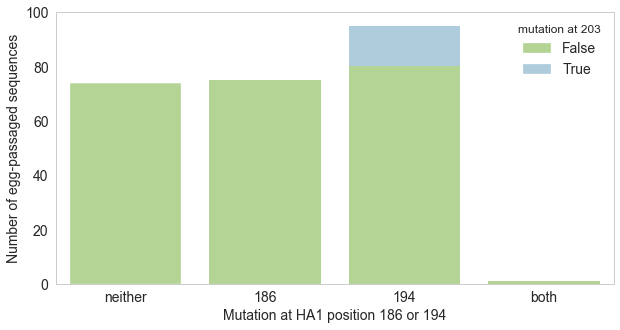

In [312]:
#CC. Position 203 only mutates if 194 is mutated
cc_df = egg_df.groupby(['mut194','mut186','mut203']).size().reset_index().rename(columns={0:'prevalence'})

cc_df['mut194_186'] = np.select(((cc_df.mut194==0)&(cc_df.mut186==0),
                                (cc_df.mut194==1)&(cc_df.mut186==0),
                                (cc_df.mut194==0)&(cc_df.mut186==1),
                                (cc_df.mut194==1)&(cc_df.mut186==1)
                               ),('neither','194','186','both'))

cc_df = cc_df.loc[:,['mut194_186','mut203', 'prevalence']]

cc_df
n_203= [74,75,80,1]
y_203= [0,0,15,0]

r = [0,1,2,3]
bars= ['neither','186','194','both']

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(r, n_203, color='#b2df8a', edgecolor='white', label='False')
sns.barplot(r, y_203, bottom=n_203, color='#a6cee3', edgecolor='white', label='True')
plt.xticks(r, bars)
ax.tick_params(axis='both', labelsize=14)
plt.ylim(0,100)
plt.legend(title='mutation at 203',fontsize=14, loc=1)
ax.grid(False)
plt.xlabel('Mutation at HA1 position 186 or 194', size=14)
plt.ylabel('Number of egg-passaged sequences', size=14)

Text(0,0.5,u'Number of egg-passaged sequences')

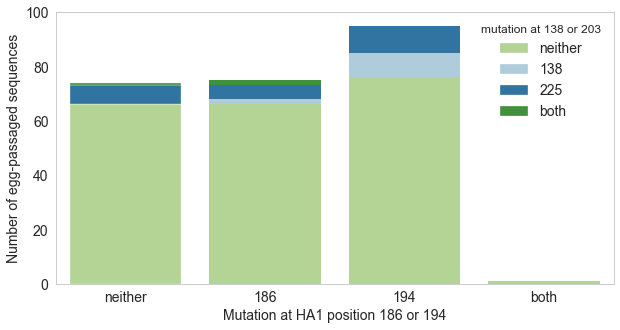

In [326]:
#CCC. Positions 138 and 203 are more general
ccc_df = egg_df.groupby(['mut194','mut186','mut138','mut225']).size().reset_index().rename(columns={0:'prevalence'})

ccc_df['mut194_186'] = np.select(((ccc_df.mut194==0)&(ccc_df.mut186==0),
                                (ccc_df.mut194==1)&(ccc_df.mut186==0),
                                (ccc_df.mut194==0)&(ccc_df.mut186==1),
                                (ccc_df.mut194==1)&(ccc_df.mut186==1)
                               ),('neither','194','186','both'))
ccc_df['mut138_225'] = np.select(((ccc_df.mut138==0)&(ccc_df.mut225==0),
                                (ccc_df.mut138==1)&(ccc_df.mut225==0),
                                (ccc_df.mut138==0)&(ccc_df.mut225==1),
                                (ccc_df.mut138==1)&(ccc_df.mut225==1)
                               ),('neither','138','225','both'))
ccc_df = ccc_df.loc[:,['mut194_186','mut138_225', 'prevalence']]

n_138_225= [66,66,76,1]
only_138= [0,2,9,0]
only_225= [7,5,10,0]
b_138_225= [1,2,0,0]

r = [0,1,2,3]
bars= ['neither','186','194','both']

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(r, n_138_225, color='#b2df8a', edgecolor='white', label='neither')
sns.barplot(r, only_138, bottom=n_138_225, color='#a6cee3', edgecolor='white', label='138')
sns.barplot(r, only_225, bottom=np.array(n_138_225)+np.array(only_138), color='#1f78b4', edgecolor='white', label='225')
sns.barplot(r, b_138_225, bottom=np.array(n_138_225)+np.array(only_138)+np.array(only_225), color='#33a02c', edgecolor='white', label='both')
plt.xticks(r, bars)
ax.tick_params(axis='both', labelsize=14)
plt.ylim(0,100)
plt.legend(title='mutation at 138 or 203',fontsize=14, loc=1)
ax.grid(False)
plt.xlabel('Mutation at HA1 position 186 or 194', size=14)
plt.ylabel('Number of egg-passaged sequences', size=14)

In [136]:
#D. 94% of seqs with mutation at 156 and/or 219 also have mut at 186


  160_aa         y
0      A  1.000000
1      I  1.000000
2      K  0.709251
3      R  1.000000
4      T  0.333333


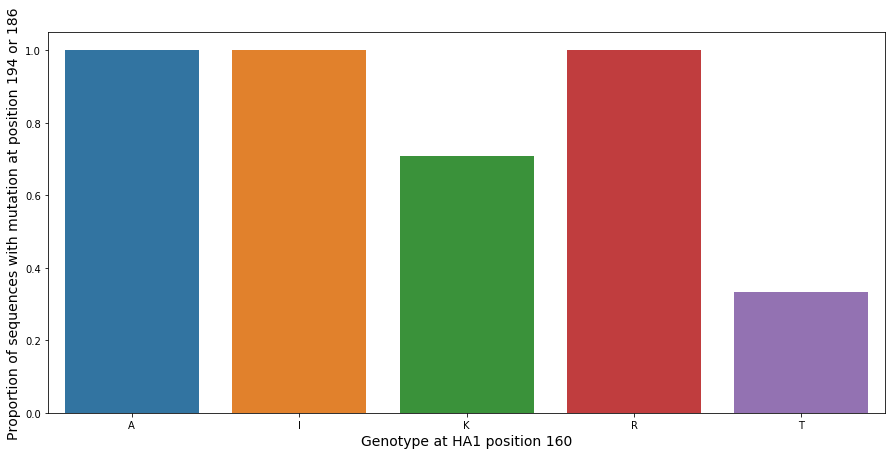

In [160]:
#E. Mutations occur preferentially in strains with 160 NOT = T

#Add column that is True is either 194 or 186 is mutated
egg_df['mut194_186']=np.select(((egg_df.mut194==1)|(egg_df.mut186==1), (egg_df.mut194==0)&(egg_df.mut186==0)), (True, False))

e_group = egg_df.groupby('160')['mut194_186'].value_counts(normalize=True)
e_dict = {}
for (aa, mut), g in e_group.iteritems():
    if mut==True:
        e_dict[aa]=[g]

e_df = pd.DataFrame(e_dict).T.reset_index().rename(columns={'index':'160_aa', 0:'y'})
fig, ax = plt.subplots(figsize=(15,7))
fig = sns.barplot(x='160_aa', y='y', data=e_df, ax=ax)

plt.xlabel('Genotype at HA1 position 160', size=14)
plt.ylabel('Proportion of sequences with mutation at position 194 or 186', size=14)
print e_df

Text(0,0.5,u'Proportion of sequences with mutation\n at position 194 or 186')

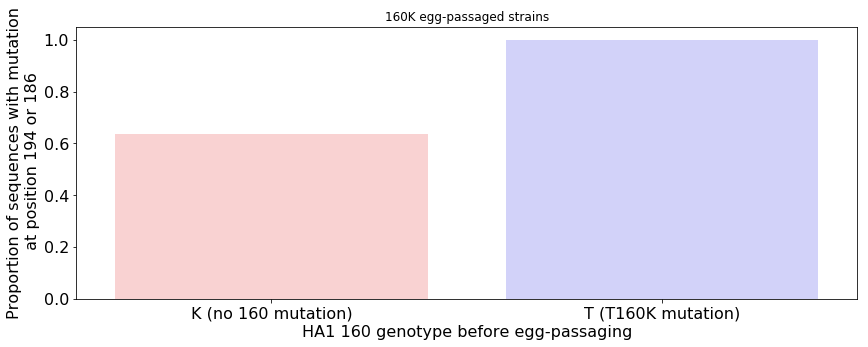

In [161]:
#F. 100% of T160K seqs mutate at an additional site (compared with 31% of other 160K seqs)

f_group = egg_df[egg_df['160']=='K'].groupby('mut160')['mut194_186'].value_counts(normalize=True)

f_dict = {}
for (aa, mut), g in f_group.iteritems():
    if mut==True:
        f_dict[aa]=[g]
        
f_df = pd.DataFrame(f_dict).T.reset_index().rename(columns={'index':'t160k_mutation', 0:'y'})
fig, ax = plt.subplots(figsize=(14,5))
fig = sns.barplot(x='t160k_mutation', y='y', data=f_df, ax=ax, palette= ['#ffcccc','#ccccff'])
ax.tick_params(axis='both', labelsize=16)
fig.set(xticklabels=['K (no 160 mutation)','T (T160K mutation)'], title='160K egg-passaged strains')
plt.xlabel('HA1 160 genotype before egg-passaging', size=16)
plt.ylabel('Proportion of sequences with mutation\n at position 194 or 186', size=16)
# ax.text(0,-.1,'160 genotype\nbefore egg-passaging',transform=ax.transAxes)

circulating160  mut160
K               0         1.0000
T               1         0.8125
                0         0.1875
Name: mut160, dtype: float64


Text(0,0.5,u'Proportion of strains mutatated at\n position 160 after egg-passaging')

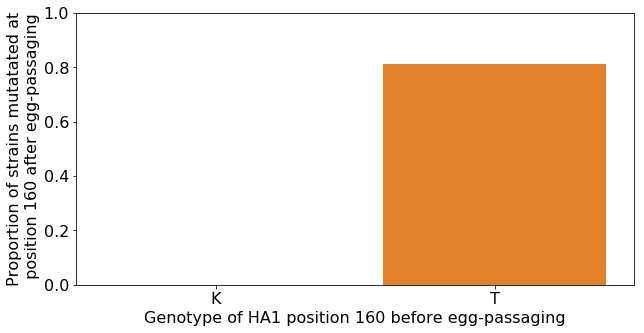

In [182]:
#G. 160 only mutates when passaged in eggs if 160=T

g_group = egg_df.groupby('circulating160')['mut160'].value_counts(normalize=True)

g_dict = {}
for (aa, mut), g in g_group.iteritems():
    if mut==True:
        g_dict[aa]=[g]
    else:
        if aa not in g_dict.keys():
            g_dict[aa]=[0.0]


g_df = pd.DataFrame(g_dict).T.reset_index().rename(columns={'index':'160_unpass', 0:'y'})
fig, ax = plt.subplots(figsize=(10,5))
fig = sns.barplot(x='160_unpass', y='y', data=g_df, ax=ax)
plt.ylim(0,1)
ax.tick_params(axis='both', labelsize=16)
plt.xlabel('Genotype of HA1 position 160 before egg-passaging', size=16)
plt.ylabel('Proportion of strains mutatated at\n position 160 after egg-passaging', size=16)

In [184]:
egg_df.groupby(['160','mut160','mut194','mut186'])['strain'].agg('count')

160  mut160  mut194  mut186
A    1       0       1          1
             1       0          1
I    1       0       1          1
             1       0          2
K    0       0       0         66
                     1         66
             1       0         48
                     1          1
     1       0       1          6
             1       0         40
R    1       1       0          1
T    0       0       0          8
                     1          1
             1       0          3
Name: strain, dtype: int64

In [183]:
egg_df.groupby(['160','mut160','mut194','mut186','mut156', 'mut219', 'mut225'])['strain'].agg('count')

160  mut160  mut194  mut186  mut156  mut219  mut225
A    1       0       1       0       0       1          1
             1       0       0       0       1          1
I    1       0       1       0       1       1          1
             1       0       0       0       0          2
K    0       0       0       0       0       0         56
                                             1          3
                             1       0       0          3
                                             1          3
                                     1       0          1
                     1       0       0       0         27
                                             1          1
                                     1       0         22
                             1       0       0         11
                                             1          1
                                     1       0          4
             1       0       0       0       0         48
                    